<a href="https://www.kaggle.com/code/hasyimabdillah/workout-classification-inceptionv3?scriptVersionId=121396611" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Necessary Modules & Packages

In [1]:
import os
import cv2
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from collections import deque
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

# Set The Hyperparameter

In [2]:
# hyperparameter
height = 256
width = 256
channels = 3
batch_size = 256
img_shape = (height, width, channels)
img_size = (height, width)

# Create, Split, and Check the Dataset

## Create Train and Validation Dataset

In [3]:
DATA_DIR = '../input/workoutexercises-images'

train_ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR,
                                                       labels = 'inferred',
                                                       label_mode = 'categorical',
                                                       validation_split = 0.1,
                                                       subset = 'training',
                                                       image_size = img_size,
                                                       shuffle = True,
                                                       batch_size = batch_size,
                                                       seed = 127
                                                      )

val_ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR,
                                                     labels = 'inferred',
                                                     label_mode = 'categorical',
                                                     validation_split = 0.1,
                                                     subset = 'validation',
                                                     image_size = img_size,
                                                     shuffle = True,
                                                     batch_size = batch_size,
                                                     seed = 127
                                                    )

labels = train_ds.class_names
print(labels)

with open('workout_label.txt', 'w') as f:
    for workout_class in labels:
        f.write(f'{workout_class}\n')

Found 13853 files belonging to 22 classes.
Using 12468 files for training.
Found 13853 files belonging to 22 classes.
Using 1385 files for validation.
['barbell biceps curl', 'bench press', 'chest fly machine', 'deadlift', 'decline bench press', 'hammer curl', 'hip thrust', 'incline bench press', 'lat pulldown', 'lateral raises', 'leg extension', 'leg raises', 'plank', 'pull up', 'push up', 'romanian deadlift', 'russian twist', 'shoulder press', 'squat', 't bar row', 'tricep dips', 'tricep pushdown']


## Augment & Check Train Dataset

In [4]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                         tf.keras.layers.GaussianNoise(10),
                                         tf.keras.layers.RandomContrast(0.1),
                                         tf.keras.layers.RandomZoom(0.2)
                                        ])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

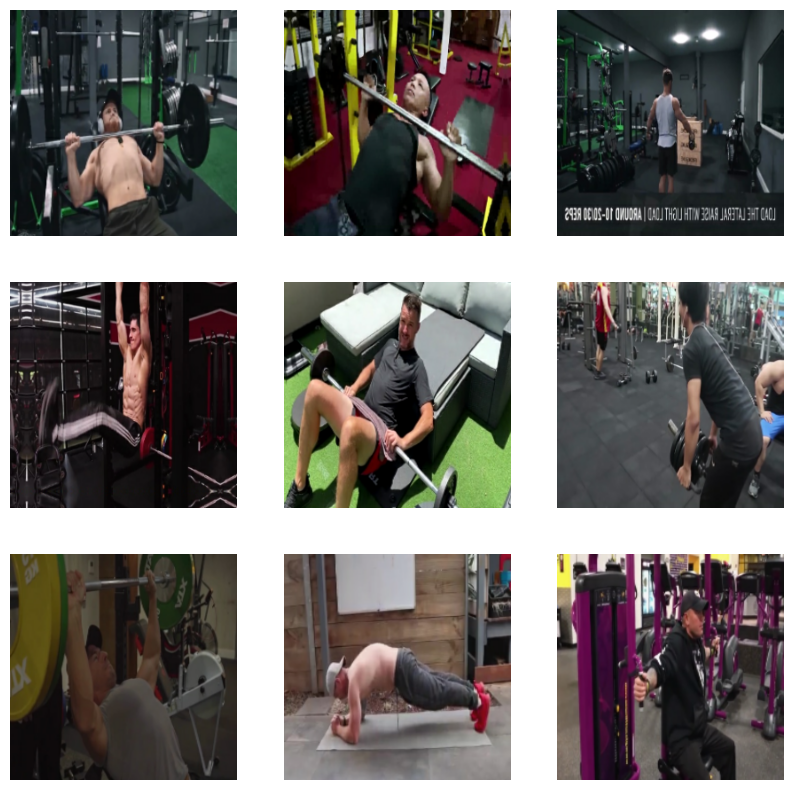

In [5]:
#Defing a function to see images
def show_img(data):
    plt.figure(figsize=(10,10))
    for images, labels in data.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")

#Plotting the images in dataset
show_img(train_ds)

# Create, Compile, Train, and Evaluate The Model

In [6]:
# load pre-trained InceptionV3
pre_trained = InceptionV3(weights='imagenet', include_top=False, input_shape=img_shape, pooling='avg')

for layer in pre_trained.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 1s 0us/step


In [7]:
x = pre_trained.output
x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
predictions = tf.keras.layers.Dense(len(labels), activation='softmax')(x)

workout_model = tf.keras.models.Model(inputs = pre_trained.input, 
                                      outputs = predictions
                                     )

workout_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy']
                     )

workout_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

## Train Model

In [8]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', 
                                        patience = 5, 
                                        mode = 'auto', 
                                        restore_best_weights = True
                                       )

history = workout_model.fit(train_ds,
                            validation_data = val_ds,
                            epochs = 100,
                            callbacks = [early_stopping_callback]
                           )

Epoch 1/100
49/49 [==============================] - 164s 3s/step - loss: 2.5281 - accuracy: 0.2744 - val_loss: 3.3688 - val_accuracy: 0.1480
Epoch 2/100
49/49 [==============================] - 132s 3s/step - loss: 1.7570 - accuracy: 0.5188 - val_loss: 2.4866 - val_accuracy: 0.2939
Epoch 3/100
49/49 [==============================] - 132s 3s/step - loss: 1.3382 - accuracy: 0.6348 - val_loss: 2.0389 - val_accuracy: 0.4000
Epoch 4/100
49/49 [==============================] - 132s 3s/step - loss: 1.0802 - accuracy: 0.7123 - val_loss: 1.8849 - val_accuracy: 0.4397
Epoch 5/100
49/49 [==============================] - 132s 3s/step - loss: 0.8954 - accuracy: 0.7634 - val_loss: 1.8054 - val_accuracy: 0.4534
Epoch 6/100
49/49 [==============================] - 133s 3s/step - loss: 0.7593 - accuracy: 0.8008 - val_loss: 1.7744 - val_accuracy: 0.4679
Epoch 7/100
49/49 [==============================] - 132s 3s/step - loss: 0.6677 - accuracy: 0.8234 - val_loss: 1.8036 - val_accuracy: 0.4578
Epoch 

## Evaluate Model

6/6 [==============================] - 5s 348ms/step - loss: 1.7558 - accuracy: 0.4744


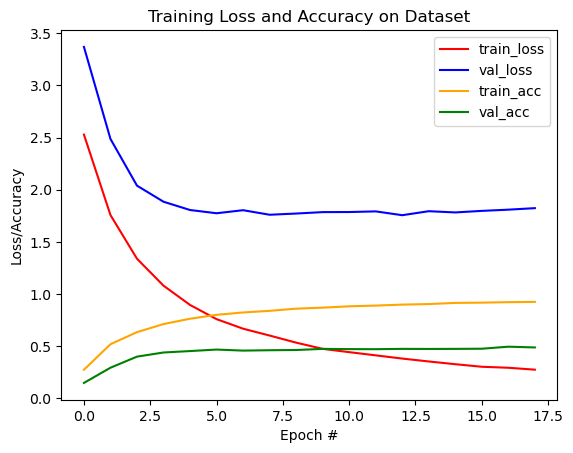

In [9]:
evaluate = workout_model.evaluate(val_ds)

epoch = range(len(history.history["loss"]))
plt.figure()
plt.plot(epoch, history.history['loss'], 'red', label = 'train_loss')
plt.plot(epoch, history.history['val_loss'], 'blue', label = 'val_loss')
plt.plot(epoch, history.history['accuracy'], 'orange', label = 'train_acc')
plt.plot(epoch, history.history['val_accuracy'], 'green', label = 'val_acc')
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

# Save and Test The Model to Predict Video

In [10]:
# Save Model
workout_model.save('workout_model')

# Save .h5 model
workout_model.save('workout_model.h5')

# Convert the model to tflite
converter = tf.lite.TFLiteConverter.from_saved_model('./workout_model')
tflite_model = converter.convert()

# Save the tflite model
with open('workout_model.tflite', 'wb') as f:
    f.write(tflite_model)

Chest fly machine/chest fly machine_18.mp4
1/1 [==============================] - 0s 28ms/step
activity:bench press
confidence: 0.15815718472003937


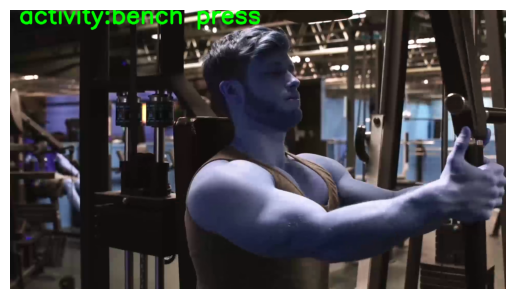

In [11]:
random_classes_names = random.choice(os.listdir('../input/workoutfitness-video'))
random_file = random.choice(os.listdir(f'../input/workoutfitness-video/{random_classes_names}'))
print(f'{random_classes_names}/{random_file}')

# Construct the input video file path
input_video_file_path = f'../input/workoutfitness-video/{random_classes_names}/{random_file}'

# Initialize video input
video_capture = cv2.VideoCapture(input_video_file_path)
writer = None
H, W = None, None
Q = deque(maxlen=128)
n = 0

# Loop through each frame in the video
while True:
    # count the frame
    n += 1
    
    # predict every 5 frame (1, 6, 11, ... etc)
    if n % 5 != 1:
        continue
    
    # read a frame
    success, frame = video_capture.read()
    
    # if frame not read properly then break the loop
    if not success:
        break
    
    # get frame dimensions
    if W is None or H is None:
        (H, W) = frame.shape[:2]
    
    # clone the frame for the output then preprocess the frame for the prediction
    output = frame.copy()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, img_size).astype("float32")
        
    predictions = workout_model.predict(np.expand_dims(frame, axis=0))[0]
    Q.append(predictions)
    
    results = np.array(Q).mean(axis=0)
    i = np.argmax(results)
    label = labels[i]
    
    text = 'activity:{}'.format(label)
    cv2.putText(output, text, (35, 50), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 10)
    
    if writer is None:
        fourcc = cv2.VideoWriter_fourcc(*"XVID")
        writer = cv2.VideoWriter('output.avi', fourcc, 30, (W, H), True)
        
    writer.write(output)
    
    plt.imshow(output)
    plt.axis('off')
    
    # break the loop if prediction > 90% and video already more than 2 seconds (60 frame)
    if results[i] >= 0.9 and n >= 60:
        break

print(text)
print(f'confidence: {results[i]}')
writer.release()
video_capture.release()